In [2]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy import integrate
import AnaUtils as au
import Triggered as tr
import glob
import os

In [2]:
pmt = "KA0220"
wdir = '/media/easystore/ReplacementPMTs'
fWaves = [os.path.splitext(iF)[0] for iF in glob.glob('{}/{}/Gain/*.bin'.format(wdir,pmt))]
fWaves.sort() 
Gains = np.array([float(iF.split('/')[-1].split('V')[0]) for iF in fWaves])
nGains = len(Gains)
print(Gains,fWaves,nGains)

[1549. 1575. 1600. 1625. 1630. 1650. 1675. 1700.] ['/media/easystore/ReplacementPMTs/KA0220/Gain/1549V_200703_100_samples_20000_events', '/media/easystore/ReplacementPMTs/KA0220/Gain/1575V_200703_100_samples_20000_events', '/media/easystore/ReplacementPMTs/KA0220/Gain/1600V_200703_100_samples_20000_events', '/media/easystore/ReplacementPMTs/KA0220/Gain/1625V_200703_100_samples_20000_events', '/media/easystore/ReplacementPMTs/KA0220/Gain/1630V_200703_100_samples_20000_events', '/media/easystore/ReplacementPMTs/KA0220/Gain/1650V_200703_100_samples_20000_events', '/media/easystore/ReplacementPMTs/KA0220/Gain/1675V_200703_100_samples_20000_events', '/media/easystore/ReplacementPMTs/KA0220/Gain/1700V_200703_100_samples_20000_events'] 8


{'numEvents': 20000, 'numSamples': 100, 'chMap': array([1, 0, 1]), 'numChan': 2, 'file': '/media/easystore/ReplacementPMTs/KA0220/Gain/1549V_200703_100_samples_20000_events'}


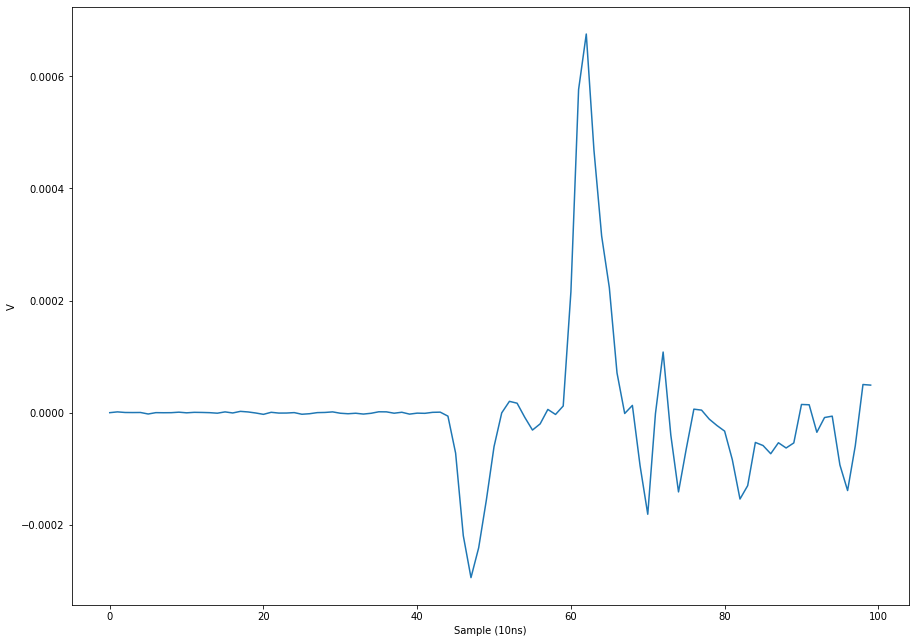

{'numEvents': 20000, 'numSamples': 100, 'chMap': array([1, 0, 1]), 'numChan': 2, 'file': '/media/easystore/ReplacementPMTs/KA0220/Gain/1575V_200703_100_samples_20000_events'}


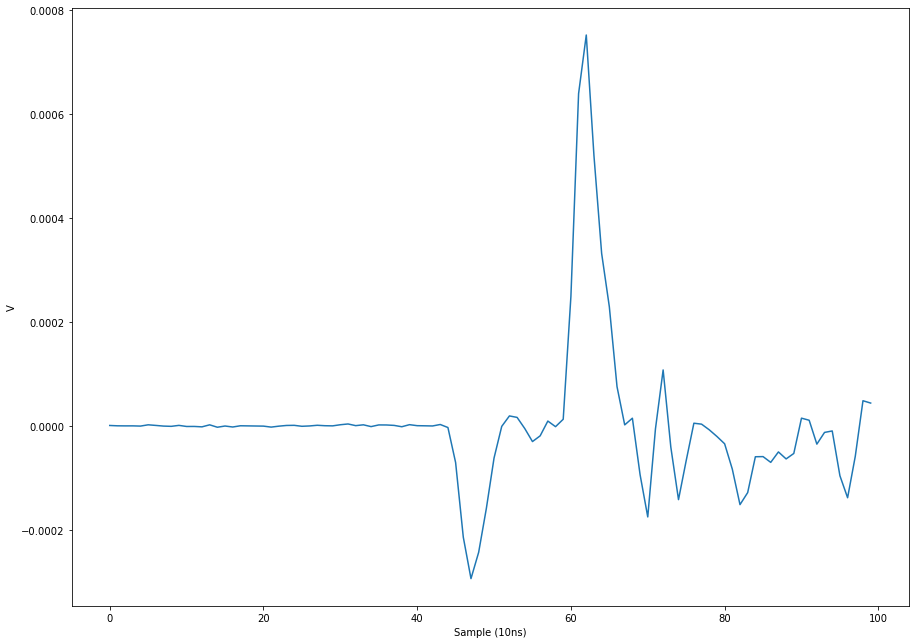

{'numEvents': 20000, 'numSamples': 100, 'chMap': array([1, 0, 1]), 'numChan': 2, 'file': '/media/easystore/ReplacementPMTs/KA0220/Gain/1600V_200703_100_samples_20000_events'}


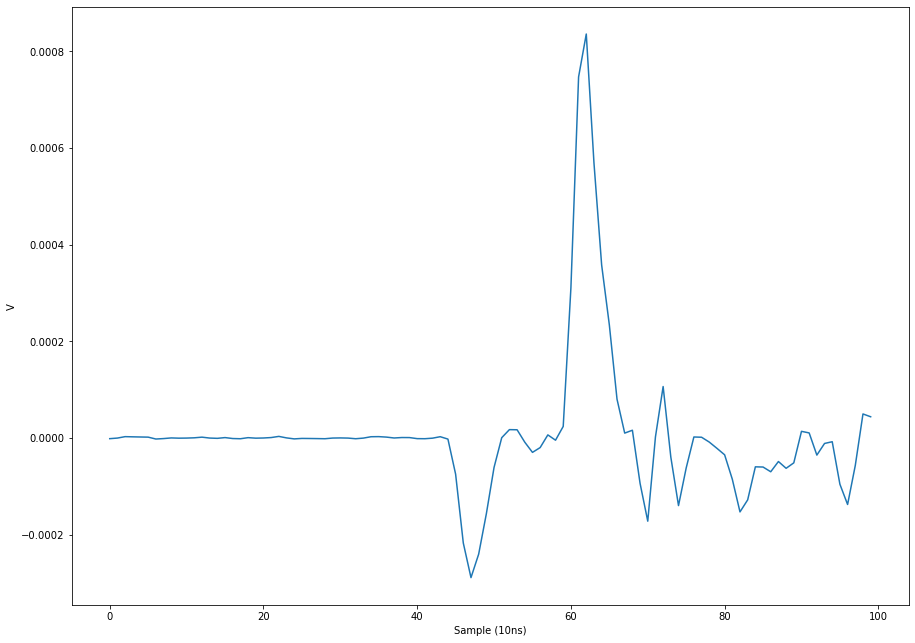

{'numEvents': 20000, 'numSamples': 100, 'chMap': array([1, 0, 1]), 'numChan': 2, 'file': '/media/easystore/ReplacementPMTs/KA0220/Gain/1625V_200703_100_samples_20000_events'}


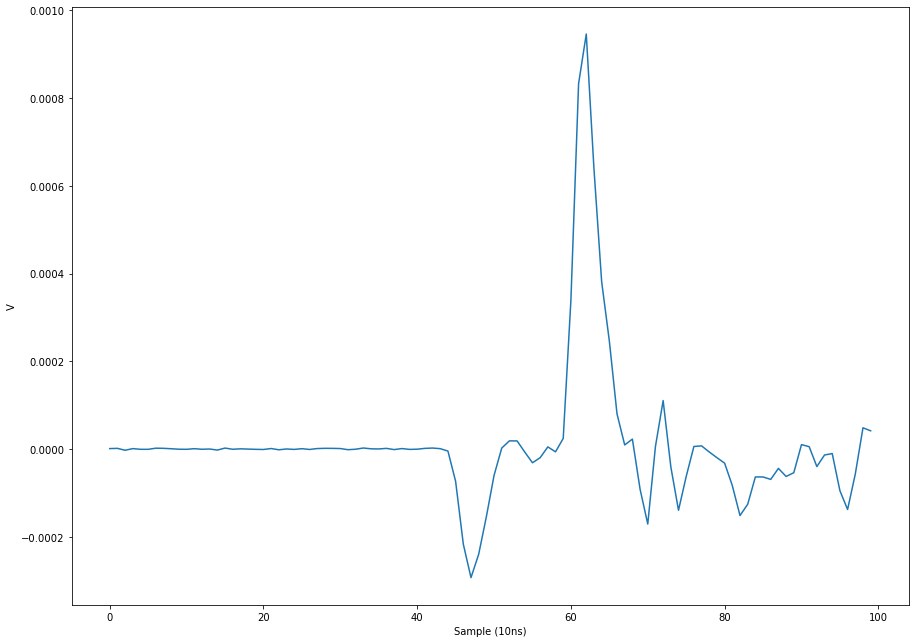

{'numEvents': 20000, 'numSamples': 100, 'chMap': array([1, 0, 1]), 'numChan': 2, 'file': '/media/easystore/ReplacementPMTs/KA0220/Gain/1630V_200703_100_samples_20000_events'}


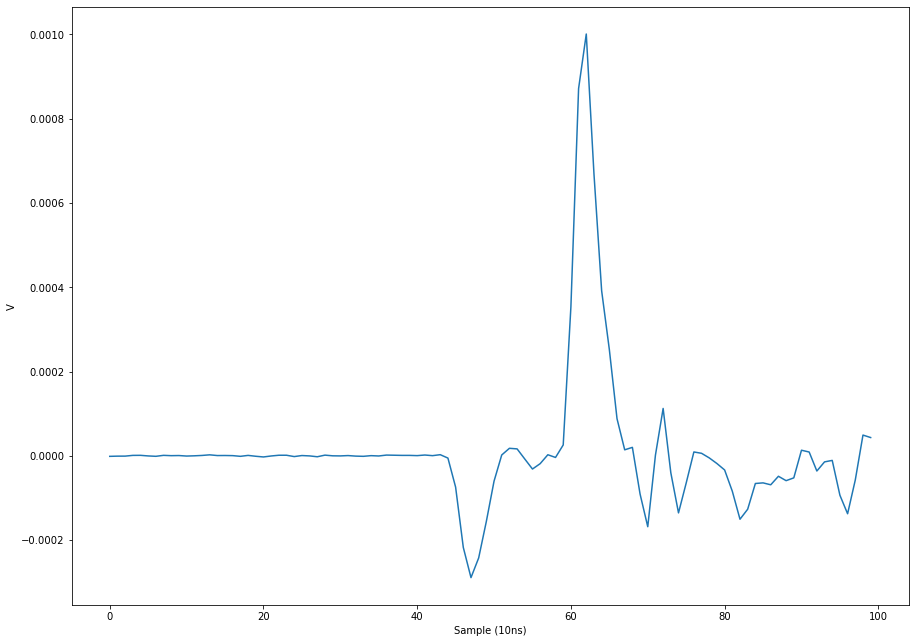

{'numEvents': 20000, 'numSamples': 100, 'chMap': array([1, 0, 1]), 'numChan': 2, 'file': '/media/easystore/ReplacementPMTs/KA0220/Gain/1650V_200703_100_samples_20000_events'}


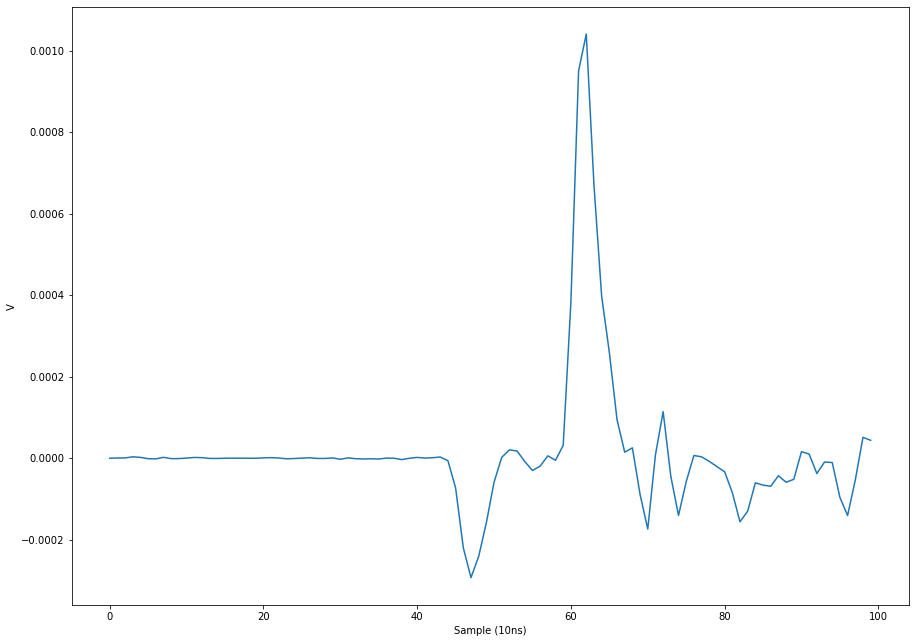

{'numEvents': 20000, 'numSamples': 100, 'chMap': array([1, 0, 1]), 'numChan': 2, 'file': '/media/easystore/ReplacementPMTs/KA0220/Gain/1675V_200703_100_samples_20000_events'}


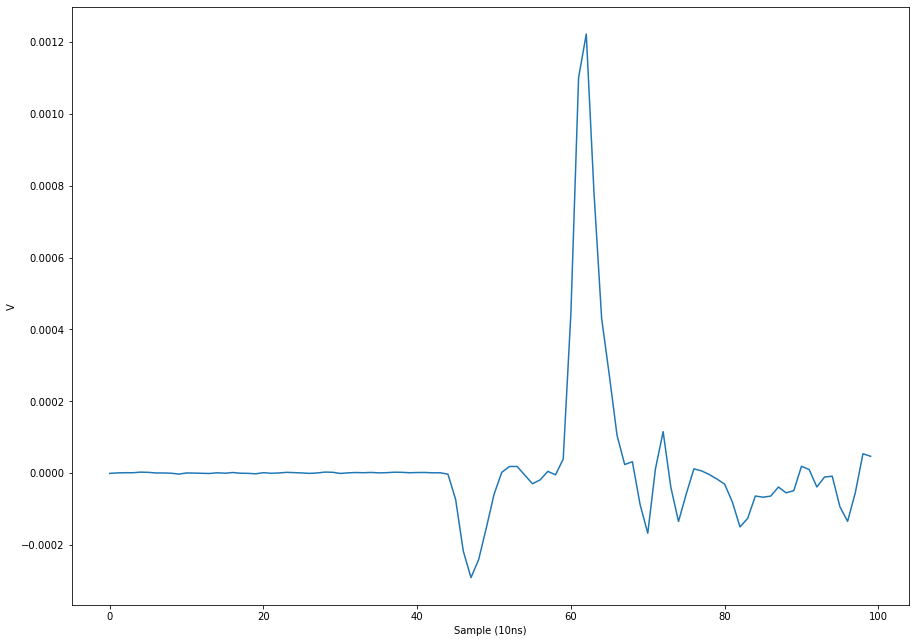

{'numEvents': 20000, 'numSamples': 100, 'chMap': array([1, 0, 1]), 'numChan': 2, 'file': '/media/easystore/ReplacementPMTs/KA0220/Gain/1700V_200703_100_samples_20000_events'}


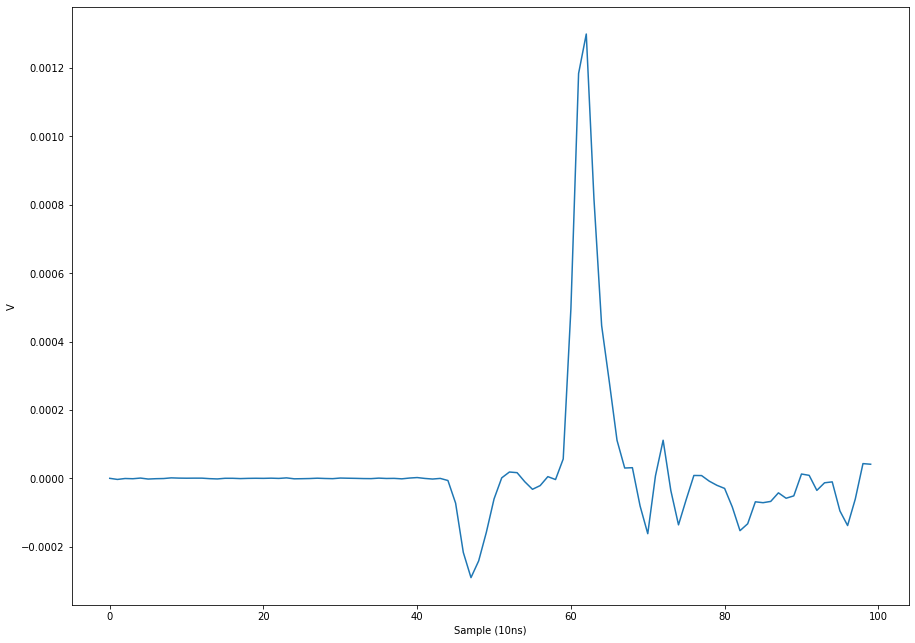

OrderedDict([('Q0', -0.024824311558557906), ('Q1', 1.0269129667558075), ('s0', 0.1453014940061242), ('s1', -0.48352840181407764), ('u', 0.33020055088656675), ('chi2', Power_divergenceResult(statistic=3.415059322545993, pvalue=1.0)), ('norm', 116.92782811123942)])
OrderedDict([('Q0', -0.026128292189071405), ('Q1', 1.194081397178213), ('s0', 0.1466507243121212), ('s1', -0.5406621020018623), ('u', 0.31641748145218856), ('chi2', Power_divergenceResult(statistic=0.7738077883264404, pvalue=1.0)), ('norm', 117.33881733714469)])
OrderedDict([('Q0', -0.03926096150244628), ('Q1', 1.5988072804816003), ('s0', 0.14637314862391387), ('s1', 0.5929440357648478), ('u', 0.3141926974204389), ('chi2', Power_divergenceResult(statistic=2.1103691829567497, pvalue=1.0)), ('norm', 117.27245826716572)])
OrderedDict([('Q0', -0.04203417681479066), ('Q1', 1.7914691466862542), ('s0', 0.14725295456920806), ('s1', 0.7635900102022285), ('u', 0.31430536423287025), ('chi2', Power_divergenceResult(statistic=1.54024703072

(array([1549., 1575., 1600., 1625., 1630., 1650., 1675., 1700.]),
 array([0.64093931, 0.74527612, 0.99788246, 1.11813079, 1.1317587 ,
        1.25310868, 1.45349285, 1.59256687]),
 array([0.0123396 , 0.01222852, 0.01087116, 0.0142471 , 0.01303863,
        0.01378355, 0.01484201, 0.01856303]),
 array([0.99115044, 1.35616438, 4.23255814, 4.27777778, 4.42857143,
        4.86666667, 6.89473684, 6.82352941]))

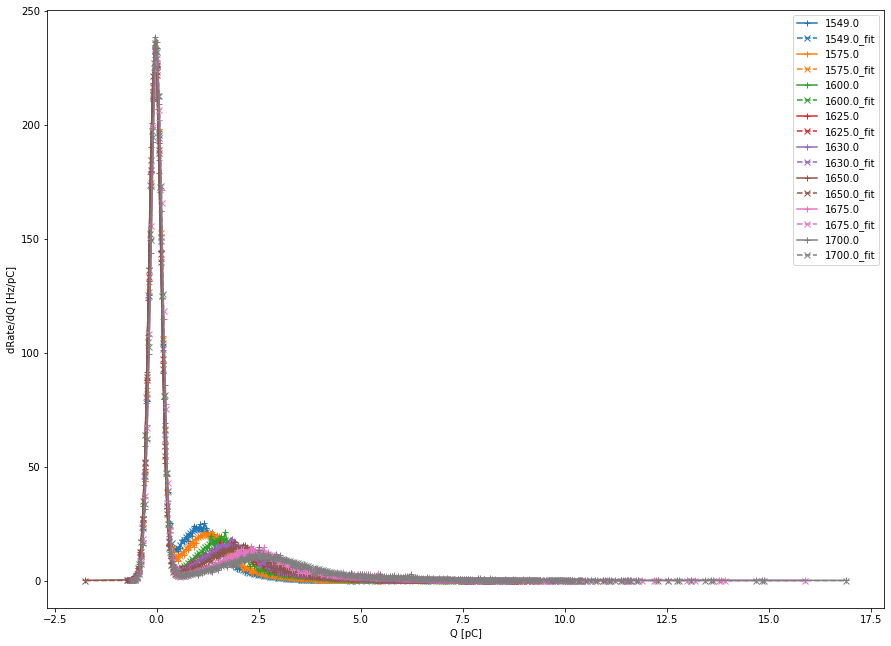

In [12]:
QHists = [tr.extRun(iG,30,3,6,qbins=100,qW=0.05,plot=False,ret=True) for iG in fWaves]
QSPE = np.array([0.]*nGains)
QErr = np.array([0.]*nGains)
QPV = np.array([0.]*nGains)
QPVErr = np.array([0.]*nGains)
for iq in range(nGains):
    #plt.plot(QHists[iq][1],QHists[iq][2],marker='x',label=Gains[iq])
    args = QHists[iq][0][3]
    lst = 'solid'
    p=plt.plot(QHists[iq][0][1][args],QHists[iq][0][0][args],marker='+',label=Gains[iq],linestyle=lst)
    try:
        P = {'Q0':0,'Q1':1.6,'s0':0.2,'s1':0.8,'u':1.5,'yq':0,'ys':0.02}
        GFit,GErr = tr.fitQP(QHists[iq][0],P,doErr=True)#,3.2,0.1,1])
        QSPE[iq] = GFit['Q1']
        print(GFit)
        QErr[iq] = np.sqrt(GErr['Q1'])
        peaki = np.argmax(QHists[iq][0][1]>QSPE[iq])
        peak0 = np.argmax(QHists[iq][0][1]>GFit['Q0'])
        peakmi = np.argmax(QHists[iq][0][1]>(GFit['Q1']-GFit['s1']))
        peakv = np.amax(QHists[iq][0][0][peakmi:])
        vallv = np.amin(QHists[iq][0][0][peak0:peaki])
        QPV[iq] = peakv/vallv
        plt.plot(QHists[iq][0][1][args],GFit['norm']*tr.gpn(QHists[iq][0][1][args],50,*list(GFit.values())[:-2]),marker='x',label='{}_fit'.format(Gains[iq]),linestyle='dashed',color=p[-1].get_color())
    except RuntimeError as e:
        print("Failed to fit {}V Run due to runtime err:\n \t{}".format(Gains[iq],e))
        lst = 'dashed'
        QSPE[iq] = np.nan
        QErr[iq] = np.nan
        QPV[iq] = np.nan
        QPVErr[iq] = np.nan
    """
    except TypeError as e:
        print("Failed to fit {}V Run due to type error:\n \t{}".format(Gains[iq],e))
        lst = 'dotted'
        QSPE[iq] = np.nan
        QErr[iq] = np.nan
        QPV[iq] = np.nan
        QPVErr[iq] = np.nan
    """
        #plt.plot(QHists[iq][1],QHists[iq][0],marker='x',label=Gains[iq])
#plt.yscale('log')
#plt.xlim(-2,10)
plt.legend()
plt.xlabel('Q [pC]')
plt.ylabel('dRate/dQ [Hz/pC]')
plt.savefig("{}/figs/{}_GainSPEs.png".format(wdir,pmt))

Gains,QSPE/1.6022,QErr,QPV

In [13]:
def fit_gain_curve(v, v0, gamma):
    q = ( v / v0 ) ** gamma
    return q
def fit_gain_line(v,v0,gamma):
    q = gamma*v + v0
    return q
qe = 1.6022e-7
from scipy.optimize import curve_fit
fitQ,fitErr = curve_fit(fit_gain_line,Gains,np.log(QSPE/qe),p0=[1,1e3],sigma=QErr/QSPE,absolute_sigma=True)
fitErr = np.sqrt(np.diag(fitErr))
print((fitQ,fitErr,(np.log(1e7)-fitQ[0])/fitQ[1]))

"""
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(Gains,np.log(QSPE/qe))
print(slope, intercept, std_err,(np.log(1e7)-intercept)/slope)
"""


(array([6.85992870e+00, 5.74669209e-03]), array([1.06358114e-01, 6.49287906e-05]), 1611.042807090879)


'\nfrom scipy.stats import linregress\nslope, intercept, r_value, p_value, std_err = linregress(Gains,np.log(QSPE/qe))\nprint(slope, intercept, std_err,(np.log(1e7)-intercept)/slope)\n'

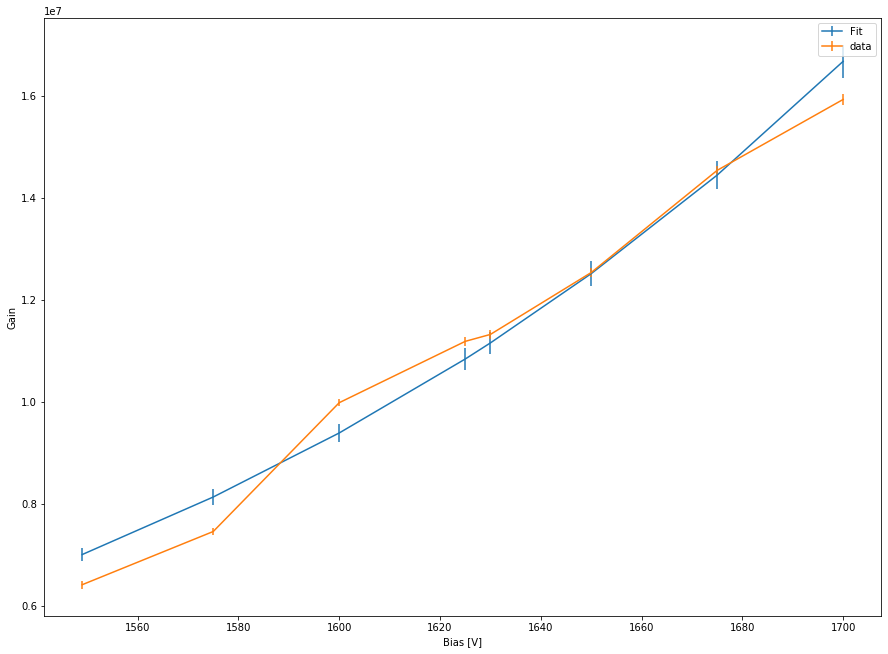

In [14]:
points = np.exp(fitQ[1] * np.array(Gains) + fitQ[0])
pointerr = np.sqrt(np.square(fitErr[1]/fitQ[1])+np.square(fitErr[0]/fitQ[0]))*points
plt.errorbar(Gains,points,yerr=pointerr,label='Fit')
plt.errorbar(Gains,QSPE/qe,label='data',yerr = QErr/qe)
plt.plot()
#plt.yscale('log')
#plt.xlim(-2,10)
plt.xlabel('Bias [V]')
plt.ylabel('Gain')
plt.legend()
plt.savefig("{}/figs/{}_GainCurve.png".format(wdir,pmt))


## 

In [ ]:
plt.plot(Gains,QPV,marker='+')
#plt.yscale('log')
#plt.xlim(-2,10)
plt.xlabel('Bias [V]')
plt.ylabel('P/V')
#plt.legend()
plt.savefig("{}/figs/{}_Peak2Valley.png".format(wdir,pmt))